# DETR Training Notebook

This notebook trains a DETR model for sign language detection. It includes data loading, model training, loss monitoring, and checkpoint saving.

## Setup and Imports


In [1]:
import sys

sys.path.append("src")

from src.data import DETRData
from src.model import DETR
from src.loss import DETRLoss, HungarianMatcher
from torch.utils.data import DataLoader
from torch import optim, load, save
from colorama import Fore
from src.utils.logger import get_logger
from src.utils.rich_handlers import TrainingHandler, rich_training_context
import sys
import torch
from src.utils.boxes import stacker
from src.logger_loss import LossLogger
import time

## Logger and Loss Logger Setup


In [ ]:
# logger
logger = get_logger("training")
logger.print_banner()
loss_logger = LossLogger()

╭───────────────────────────────────────────────────────────────╮
│                                                               │
│      _____ _       _         _    _____     _                 │
│     |   __| |_ ___|_|___ ___|_|  |  _  |___|_|___             │
│     |__   | '_|  _| | . |_ -| |  |     |- _| |- _|            │
│     |_____|_,_|_| |_|  _|___|_|  |__|__|___|_|___|            │
│                     |_|                                       │
│                                                               │
│ ╔═══════════════════════════════════════════════════════════╗ │
│ ║  🤟 Bisindo Detection with DETR                           ║ │
│ ║  🎯 Implement Real-time Finger Sign Recognition           ║ │
│ ║  🏋️ DETR (DEtection TRansformer) Model                    ║  │
│ ╚═══════════════════════════════════════════════════════════╝ │
│                                                               │
╰───────────────────────────────────────────────────────────────╯

## Dataset and DataLoader Setup


In [4]:
train_dataset = DETRData("data/train")
train_dataloader = DataLoader(
    train_dataset, batch_size=96, collate_fn=stacker, drop_last=True
)

test_dataset = DETRData("data/val", train=False)
test_dataloader = DataLoader(
    test_dataset, batch_size=4, collate_fn=stacker, drop_last=True
)

val_dataset = DETRData("data/val", train=False)
val_dataloader = DataLoader(
    val_dataset, batch_size=4, collate_fn=stacker, drop_last=True
)

        📊 Dataset Statistics        
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Metric        ┃ Value             ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Dataset Path  │ data/train        │
│ Mode          │ Training          │
│ Total Samples │ 988               │
│ Images Path   │ data/train\images │
│ Labels Path   │ data/train\labels │
└───────────────┴───────────────────┘

╭────────────────────────────────────────────── 🔄 Data Transforms ───────────────────────────────────────────────╮
│ • Resize to 500x500                                                                                             │
│ • Random Crop 224x224 (training only)                                                                           │
│ • Final Resize to 224x224                                                                                       │
│ • Horizontal Flip p=0.5 (training only)                                                                         │
│ • Color Jitter (training only)                                                                                  │
│ • Normalize (ImageNet stats)                                                                                    │
│ • Convert to Tensor                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

       📊 Dataset Statistics       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric        ┃ Value           ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Dataset Path  │ data/val        │
│ Mode          │ Testing         │
│ Total Samples │ 182             │
│ Images Path   │ data/val\images │
│ Labels Path   │ data/val\labels │
└───────────────┴─────────────────┘

╭────────────────────────────────────────────── 🔄 Data Transforms ───────────────────────────────────────────────╮
│ • Resize to 500x500                                                                                             │
│ • Random Crop 224x224 (training only)                                                                           │
│ • Final Resize to 224x224                                                                                       │
│ • Horizontal Flip p=0.5 (training only)                                                                         │
│ • Color Jitter (training only)                                                                                  │
│ • Normalize (ImageNet stats)                                                                                    │
│ • Convert to Tensor                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

       📊 Dataset Statistics       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric        ┃ Value           ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Dataset Path  │ data/val        │
│ Mode          │ Testing         │
│ Total Samples │ 182             │
│ Images Path   │ data/val\images │
│ Labels Path   │ data/val\labels │
└───────────────┴─────────────────┘

╭────────────────────────────────────────────── 🔄 Data Transforms ───────────────────────────────────────────────╮
│ • Resize to 500x500                                                                                             │
│ • Random Crop 224x224 (training only)                                                                           │
│ • Final Resize to 224x224                                                                                       │
│ • Horizontal Flip p=0.5 (training only)                                                                         │
│ • Color Jitter (training only)                                                                                  │
│ • Normalize (ImageNet stats)                                                                                    │
│ • Convert to Tensor                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## Model Setup


In [5]:
num_classes = 26
model = DETR(num_classes=num_classes)
# model.load_pretrained('pretrained/150_final_model.pt')
model.log_model_info()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)
model.train()

              🤖 DETR Model Architecture               
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Component         ┃ Details                         ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Model Type        │ DETR (Detection Transformer)    │
│ Number of Classes │ 26                              │
│ Hidden Dimension  │ 256                             │
│ Attention Heads   │ 8                               │
│ Encoder Layers    │ 1                               │
│ Decoder Layers    │ 1                               │
│ Object Queries    │ 25                              │
│ Backbone          │ ResNet-50 (ImageNet pretrained) │
└───────────────────┴─────────────────────────────────┘

           📊 Model Parameters           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Parameter Type           ┃ Count      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ Total Parameters         │ 26,942,815 │
│ Trainable Parameters     │ 26,942,815 │
│ Non-trainable Parameters │ 0          │
└──────────────────────────┴────────────┘

Using device: cpu


DETR(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

## Optimizer, Scheduler, and Loss Setup


In [12]:
opt = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.SequentialLR(
    opt,
    schedulers=[
        optim.lr_scheduler.LinearLR(
            opt, start_factor=0.1, end_factor=1.0, total_iters=10
        ),  # Warmup for 10 epochs
        optim.lr_scheduler.CosineAnnealingWarmRestarts(
            opt, len(train_dataloader) * 30, T_mult=2
        ),
    ],
    milestones=[10],
)

weights = {"class_weighting": 1, "bbox_weighting": 5, "giou_weighting": 2}
matcher = HungarianMatcher(weights)
criterion = DETRLoss(
    num_classes=num_classes, matcher=matcher, weight_dict=weights, eos_coef=0.1
)

# Move criterion to device
criterion = criterion.to(device)

NameError: name 'train_dataloader' is not defined

## Training Configuration and Loop


In [7]:
train_batches = len(train_dataloader)
test_batches = len(test_dataloader)
epochs = 1000

In [ ]:
# Start training with rich context and FP16 (AMP)
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
with rich_training_context() as training_handler:
    for epoch in range(epochs):
        with training_handler.create_training_progress() as epoch_progress:
            epoch_task = epoch_progress.add_task(
                f"[bold blue] Progress {epoch+1}/{epochs}",
                train_loss=0.0,
                test_loss=0.0,
                total=train_batches,
            )
            # Training phase
            model.train()
            train_epoch_loss = 0.0

            # Create progress bar for current epoch
            for batch_idx, batch in enumerate(train_dataloader):
                X, y = batch
                X = X.to(device)
                y = [{k: v.to(device) for k, v in target.items()} for target in y]
                try:
                    with autocast():
                        yhat = model(X)
                        yhat_classes = yhat["pred_logits"]
                        yhat_bb = yhat["pred_boxes"]
                        loss_dict = criterion(yhat, y)
                        weight_dict = criterion.weight_dict

                        losses = (
                            loss_dict["labels"]["loss_ce"]
                            * weight_dict["class_weighting"]
                            + loss_dict["boxes"]["loss_bbox"]
                            * weight_dict["bbox_weighting"]
                            + loss_dict["boxes"]["loss_giou"]
                            * weight_dict["giou_weighting"]
                        )

                    # Calculate loss
                    train_epoch_loss += losses.item()

                    # Zero grads
                    opt.zero_grad()

                    # Backward & optimizer step with scaler
                    scaler.scale(losses).backward()
                    scaler.step(opt)
                    scaler.update()

                    # Update progress
                    epoch_progress.update(
                        epoch_task,
                        advance=1,
                        train_loss=round(train_epoch_loss / train_batches, 5),
                    )

                except Exception as e:
                    logger.error(
                        f"Training error at epoch {epoch}, batch {batch_idx}: {str(e)}"
                    )
                    logger.error(f"Batch targets: {str(y)}")
                    sys.exit()

            # Test phase
            model.eval()
            test_epoch_loss = 0.0
            with torch.no_grad():
                for batch_idx, batch in enumerate(test_dataloader):
                    X, y = batch
                    X = X.to(device)
                    y = [{k: v.to(device) for k, v in target.items()} for target in y]
                    with autocast():
                        yhat = model(X)
                        loss_dict = criterion(yhat, y)
                        weight_dict = criterion.weight_dict
                        losses = (
                            loss_dict["labels"]["loss_ce"]
                            * weight_dict["class_weighting"]
                            + loss_dict["boxes"]["loss_bbox"]
                            * weight_dict["bbox_weighting"]
                            + loss_dict["boxes"]["loss_giou"]
                            * weight_dict["giou_weighting"]
                        )

                    # Calculate loss
                    test_epoch_loss += losses.item()
                    epoch_progress.update(
                        epoch_task,
                        advance=0,
                        test_loss=round(test_epoch_loss / test_batches, 5),
                    )

            # Avg loss
            avg_train_loss = round(train_epoch_loss / train_batches, 5)
            avg_test_loss = round(test_epoch_loss / test_batches, 5)
            current_lr = opt.param_groups[0]["lr"]

            elapsed_time = epoch_progress.tasks[epoch_task].elapsed
            epoch_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

            # Print epoch summary
            print(
                f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}, LR: {current_lr:.6f}, Time: {epoch_time}"
            )

            # Save ke CSV
            loss_logger.log(
                epoch + 1, avg_train_loss, avg_test_loss, current_lr, epoch_time
            )

            # Progress lr
            scheduler.step()

            # Save checkpoints
            if epoch % 10 == 0 and epoch != 0:
                checkpoint_path = f"checkpoints/{epoch}_model.pt"
                save(model.state_dict(), checkpoint_path)
                training_handler.save_checkpoint_status(checkpoint_path, epoch)

# Final save
save(model.state_dict(), f"checkpoints/{epoch}_model.pt")

## Loss Monitoring and Visualization


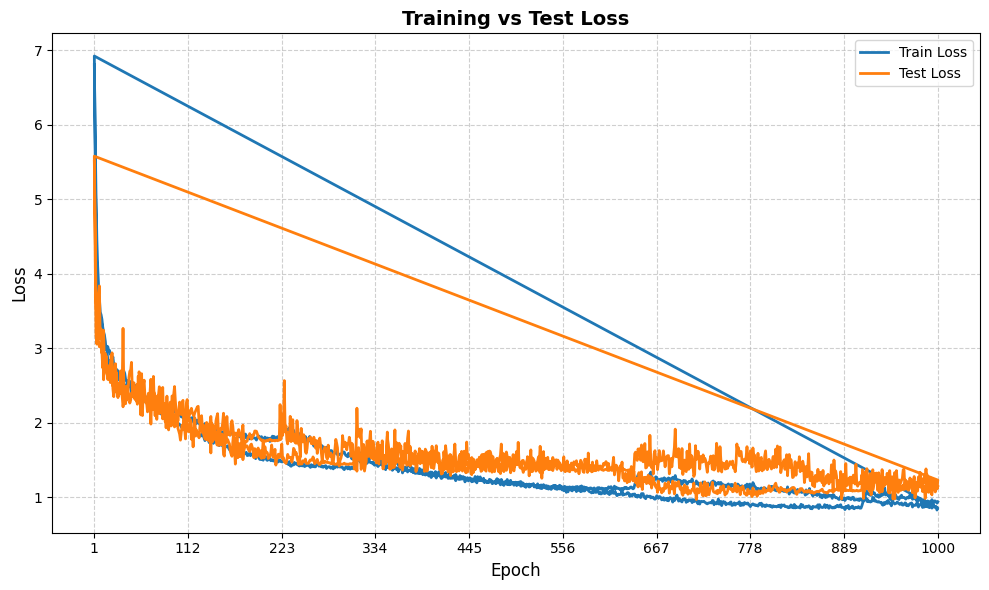

In [13]:
from src.plot_loss import plot_loss

# Plot the loss curve after training
plot_loss()

In [4]:
import torch
from torch.utils.data import DataLoader
import pandas as pd

# Assuming you have train_dataloader, val_dataloader, test_dataloader defined
# If not, adjust accordingly


def evaluate_model(model, dataloader, device, matcher, num_classes=26):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_iou = 0.0
    num_boxes = 0

    per_class_correct = {i: 0 for i in range(num_classes)}
    per_class_total = {i: 0 for i in range(num_classes)}
    per_class_iou_sum = {i: 0.0 for i in range(num_classes)}
    per_class_iou_count = {i: 0 for i in range(num_classes)}

    def box_iou(box1, box2):
        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2
        x1_min = x1 - w1 / 2
        y1_min = y1 - h1 / 2
        x1_max = x1 + w1 / 2
        y1_max = y1 + h1 / 2
        x2_min = x2 - w2 / 2
        y2_min = y2 - h2 / 2
        x2_max = x2 + w2 / 2
        y2_max = y2 + h2 / 2
        inter_x_min = max(x1_min, x2_min)
        inter_y_min = max(y1_min, y2_min)
        inter_x_max = min(x1_max, x2_max)
        inter_y_max = min(y1_max, y2_max)
        inter_area = max(0, inter_x_max - inter_x_min) * max(
            0, inter_y_max - inter_y_min
        )
        box1_area = (x1_max - x1_min) * (y1_max - y1_min)
        box2_area = (x2_max - x2_min) * (y2_max - y2_min)
        union_area = box1_area + box2_area - inter_area
        return inter_area / union_area if union_area > 0 else 0

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = [{k: v.to(device) for k, v in target.items()} for target in y]
            yhat = model(X)

            for i in range(len(y)):
                pred_logits = yhat["pred_logits"][i]
                pred_boxes = yhat["pred_boxes"][i]
                tgt_labels = y[i]["labels"]
                tgt_boxes = y[i]["boxes"]

                yhat_sample = {
                    "pred_logits": pred_logits.unsqueeze(0),
                    "pred_boxes": pred_boxes.unsqueeze(0),
                }
                y_sample = [{"labels": tgt_labels, "boxes": tgt_boxes}]
                indices = matcher(yhat_sample, y_sample)
                pred_indices, tgt_indices = indices[0]

                for p, t in zip(pred_indices, tgt_indices):
                    pred_class = pred_logits[p].argmax().item()
                    tgt_class = tgt_labels[t].item()

                    per_class_total[tgt_class] += 1
                    if pred_class == tgt_class:
                        total_correct += 1
                        per_class_correct[pred_class] += 1

                    iou = box_iou(pred_boxes[p].cpu(), tgt_boxes[t].cpu())
                    total_iou += iou
                    num_boxes += 1
                    per_class_iou_sum[tgt_class] += iou
                    per_class_iou_count[tgt_class] += 1

                total_samples += len(tgt_labels)

    accuracy = total_correct / total_samples if total_samples > 0 else 0
    avg_iou = total_iou / num_boxes if num_boxes > 0 else 0

    per_class_metrics = []
    for cls in range(num_classes):
        acc = (
            per_class_correct[cls] / per_class_total[cls]
            if per_class_total[cls] > 0
            else 0
        )
        avg_iou_cls = (
            per_class_iou_sum[cls] / per_class_iou_count[cls]
            if per_class_iou_count[cls] > 0
            else 0
        )
        per_class_metrics.append(
            {
                "Class": cls,
                "Accuracy": acc,
                "Avg IoU": avg_iou_cls,
                "Samples": per_class_total[cls],
            }
        )

    return accuracy, avg_iou, per_class_metrics


# Evaluate on train, val, test
datasets = {
    "Train": train_dataloader,
    "Validation": val_dataloader,  # Assuming you have val_dataloader
    "Test": test_dataloader,
}

for name, dataloader in datasets.items():
    if dataloader is not None:
        accuracy, avg_iou, per_class_metrics = evaluate_model(
            model, dataloader, device, matcher
        )
        print(f"\n{name} Results:")
        print(f"Classification Accuracy: {accuracy:.4f}")
        print(f"Average IoU: {avg_iou:.4f}")
        print("\nPer-Class Metrics:")
        df = pd.DataFrame(per_class_metrics)
        print(df.to_string(index=False))
    else:
        print(f"\n{name} dataloader not available.")

NameError: name 'train_dataloader' is not defined

## Testing the Model

This section tests the trained DETR model on the test dataset, similar to the test.py script.


In [3]:
import matplotlib.pyplot as plt
from src.utils.boxes import rescale_bboxes
from src.utils.setup import get_classes
from src.utils.rich_handlers import TestHandler, DetectionHandler

# Initialize handlers
test_handler = TestHandler()
detection_handler = DetectionHandler()

# Create test dataset
test_dataset = DETRData("data/test", train=False)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=4, drop_last=True)

# Model is already loaded and trained, set to eval mode
model.eval()


# Get a batch from test data
X, y = next(iter(test_dataloader))

logger.test("Running inference on test batch...")

import time

start_time = time.time()
with torch.no_grad():
    result = model(X.to(device))
inference_time = (time.time() - start_time) * 1000  # Convert to ms

# Move results to CPU for processing
result = {k: v.cpu() for k, v in result.items()}

probabilities = result["pred_logits"].softmax(-1)[:, :, :-1]
max_probs, max_classes = probabilities.max(-1)
keep_mask = max_probs > 0.6
batch_indices, query_indices = torch.where(keep_mask)

bboxes = rescale_bboxes(
    result["pred_boxes"][batch_indices, query_indices, :], (224, 224)
)
classes = max_classes[batch_indices, query_indices]
probas = max_probs[batch_indices, query_indices]

# Log inference timing
detection_handler.log_inference_time(inference_time)

# Prepare detection results for logging
detections = []
for i in range(len(classes)):
    detections.append(
        {
            "class": get_classes()[classes[i].item()],
            "confidence": probas[i].item(),
            "bbox": bboxes[i].detach().cpu().numpy().tolist(),
        }
    )

# Log detection results
detection_handler.log_detections(detections)

CLASSES = get_classes()

fig, ax = plt.subplots(2, 2)
axs = ax.flatten()
for idx, (img, ax) in enumerate(zip(X, axs)):
    ax.imshow(img.permute(1, 2, 0).cpu())
    for batch_idx, box_class, box_prob, bbox in zip(
        batch_indices, classes, probas, bboxes
    ):
        if batch_idx == idx:
            xmin, ymin, xmax, ymax = bbox.detach().cpu().numpy()
            ax.add_patch(
                plt.Rectangle(
                    (xmin, ymin),
                    xmax - xmin,
                    ymax - ymin,
                    fill=False,
                    color=(0.000, 0.447, 0.741),
                    linewidth=3,
                )
            )
            text = f"{CLASSES[box_class]}: {box_prob:0.2f}"
            ax.text(
                xmin, ymin, text, fontsize=15, bbox=dict(facecolor="yellow", alpha=0.5)
            )

fig.tight_layout()
plt.show()

       📊 Dataset Statistics        
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric        ┃ Value            ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Dataset Path  │ data/test        │
│ Mode          │ Testing          │
│ Total Samples │ 130              │
│ Images Path   │ data/test\images │
│ Labels Path   │ data/test\labels │
└───────────────┴──────────────────┘

╭────────────────────────────────────────────── 🔄 Data Transforms ───────────────────────────────────────────────╮
│ • Resize to 500x500                                                                                             │
│ • Random Crop 224x224 (training only)                                                                           │
│ • Final Resize to 224x224                                                                                       │
│ • Horizontal Flip p=0.5 (training only)                                                                         │
│ • Color Jitter (training only)                                                                                  │
│ • Normalize (ImageNet stats)                                                                                    │
│ • Convert to Tensor                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

NameError: name 'model' is not defined